# Attempt to explain greedy sampling

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import hdfdict
import h5py
from scipy.stats import wasserstein_distance
from toolz.curried import curry, pipe, get, compose, valmap
from toolz.curried import map as fmap

In [187]:
def sequence(*args):
    return compose(*args[::-1])

In [188]:
def calc_x_d(data):
    zmax = data.max() + 0.2 * data.max()
    zmin = data.min() + 0.2 * data.min()
    return np.linspace(zmin, zmax, 2000)

def density_function_(x_d, data):
    return pipe(
        KernelDensity(kernel='gaussian'),
        lambda x: x.fit(data[:, None]),
        lambda x: x.score_samples(x_d[:, None]),
        np.exp
    )

@curry
def density_function(x_d, data):
    """Calculate a probability density function 
    
    Uses a Gaussian kernel. 
    
    Args:
      x_d: the probabilty space. If None then this is calculated.
      data: a 1D array of data
      
    Returns:
      a tuple of the probability space (2000 points) and the density
      function over that probabilty space.
    """
    return pipe(
        calc_x_d(data) if x_d is None else x_d,
        lambda x: (x, density_function_(x, data))
    )


In [260]:
@curry
def dis_curve_(f_dis, data_all, n_iter, data_sub):
    """Calculate the distance curves.
    
    Calculates the distance between data_all and sequences of
    data_sub that get larger by 1. The first point uses len(data_sub) - n_iter points
    the second point uses len(data_sub) - n_iter + 1 points. Used to calculate
    the Wasserstein distance for active learning curves.
    
    Args:
      f_dis: probability density function distance function
      data_all: 1D array that includes all the data
      n_iter: the total number of iterations from the active learning curve
      data_sub: the data selected during the active learning curve. This should
        be greater than the n_iter
        
    Returns:
      a 1D array of distances of length n_iter + 1
    
    """
    @curry
    def helper(x, y, i):
        return pipe(
            data_sub[:(len(data_sub) - n_iter + i)],
            density_function(x),
            get(1),
            curry(f_dis)(y)
        )
    return pipe(
        range(n_iter + 1),
        fmap(helper(*density_function(None, data_all))),
        list
    )

In [261]:
@curry
def calc_curve(f_curve, single_active_data):
    return pipe(
        single_active_data,
        fmap(f_curve),
        list,
        np.array,
        lambda x: x.mean(axis=0)
    )
    

In [298]:
def all_curves(all_data, some_data, n_iter, f_dis, f_help):
    f_curve = dis_curve_(f_dis, all_data, n_iter)
    
    helper = sequence(
        f_help,
        calc_curve(f_curve),
    )

    return valmap(helper, some_data)

In [299]:
def all_curves_x(pca_data, active_data, n_iter, f_dis, pc_axis=0):
    return all_curves(
        pca_data[:, pc_axis],
        active_data,
        n_iter,
        f_dis,
        lambda x: x['x_train_list'][:, :, pc_axis]
    )

In [300]:
def all_curves_y(y_data, active_data, n_iter, f_dis):
    return all_curves(
        y_data,
        active_data,
        n_iter,
        f_dis,
        lambda x: x['y_train_list']
    )

In [305]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

## Load the data

Loading both the raw PCA data and the data from generating the active learning curves.

In [295]:
data = np.load('data_pca-500-51-51.npz')
x_data_pca = data['x_data_pca'][:]
y_data = data['y_data']

In [296]:
fname = 'output_500-51-51-51_with_xtrain3.h5'
f = h5py.File(fname, 'r')
output_active = hdfdict.load(fname)
f.close()

## Plot the Wasserstein curves for first PCA axis

In [301]:
return_values = all_curves_x(x_data_pca, output_active, 100, wasserstein_distance)

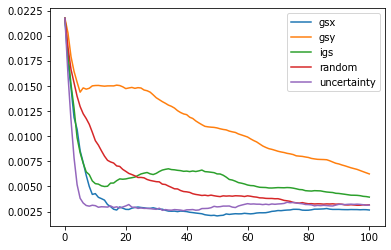

In [302]:
for k in return_values:
    plt.plot(return_values[k], label=k)
plt.legend()

## Plot the Wasserstein curves for second PCA axis

In [308]:
return_values = all_curves_x(x_data_pca, output_active, 100, wasserstein_distance, pc_axis=1)

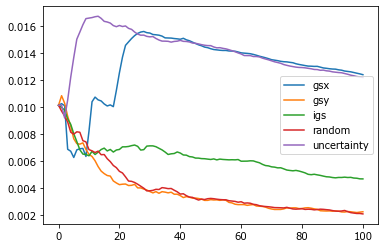

In [309]:
for k in return_values:
    plt.plot(return_values[k], label=k)
plt.legend()

## Plot the Wasserstein curves for y data

In [290]:
return_values = all_curves_y(y_data, output_active, 100, wasserstein_distance)

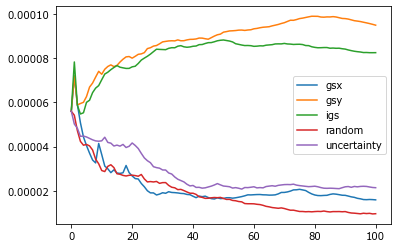

In [291]:
for k in return_values:
    plt.plot(return_values[k], label=k)
plt.legend()

## Plot the KL divergence distance curves (PC=0)

In [306]:
return_values = all_curves_x(x_data_pca, output_active, 100, kl_divergence)

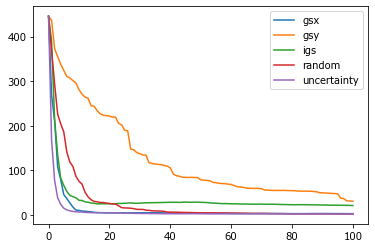

In [307]:
for k in return_values:
    plt.plot(return_values[k], label=k)
plt.legend()

## Plot the KL divergence distance curves (PC=1)

In [310]:
return_values = all_curves_x(x_data_pca, output_active, 100, kl_divergence, pc_axis=1)

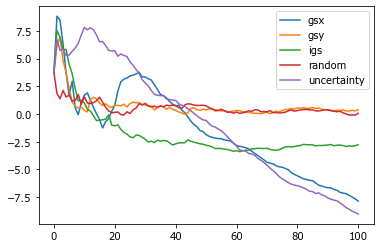

In [311]:
for k in return_values:
    plt.plot(return_values[k], label=k)
plt.legend()

## Hacking

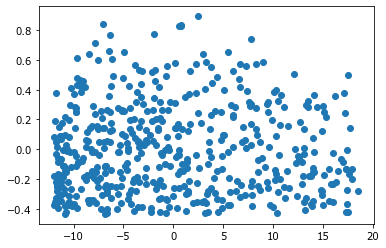

In [202]:
plt.scatter(x_data_pca[:, 0], x_data_pca[:, 1])

In [203]:
x_den, y_den = density_function(None, x_data_pca[:, 0])

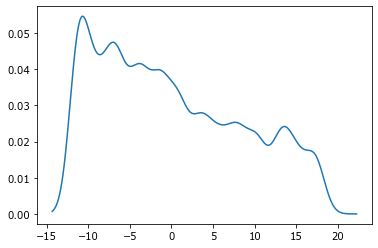

In [204]:
plt.plot(x_den, y_den)